In this class, we will talk about model explainability but more in the context of data explainability or root cause analysis. In many cases building a very good machine learning model is not an ultimate goal. What is really wanted is the data understanding. A factory wants to know why the product is plagued with a defect, not to predict afterward if there is a defect or not. A football team wants to know which position is the best for scoring a goal, not what's the probability of scoring from a given position. And even when they want a prediction they would love to see the justification to trust the model. Often a nice plot is worth more than sophisticated machine-learning approaches.

In [1]:
import pandas as pd
import numpy as np
import dalex as dx #library for model explainability
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_wine
from sklearn_extra.cluster import KMedoids

In [2]:
data = load_wine()

In [3]:
data
df = pd.DataFrame(data['data'], columns=data['feature_names'])
y = data['target']
df['target'] = y

In [4]:
df.head()

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  target  
0                          3.92   1065.0       0  
1                          3.40   1050.0       0  
2                          3.17   1185.0       0  
3                          3.45   1480.0       0  
4                          2.93    735.0       0

You should already be familiar with many data visualization techniques so we will not train it now. I just want to share a less popular type of data analysis. Usually plotting the target against any feature is not helpful but after some modification, we might be able to see some patterns.

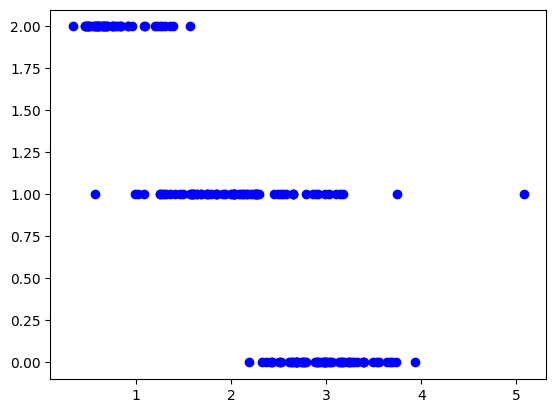

In [5]:
plt.plot(df.flavanoids, y, 'bo')
# bo -> blue circles

For each value, we can plot the average target for data:
 - below that value
 - above that value
 - around that value

Please note that for the line "above that value" the more left we go the higher fraction of data is covered. The same with the "below that value"

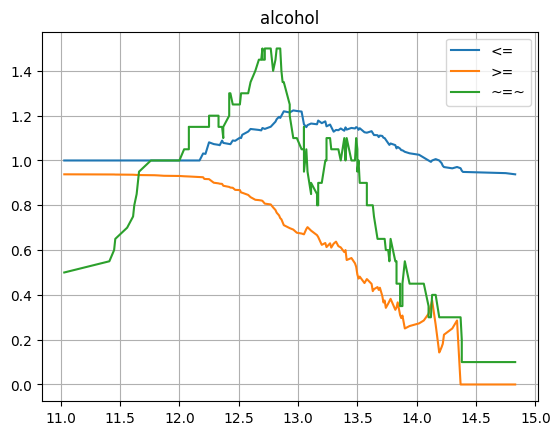

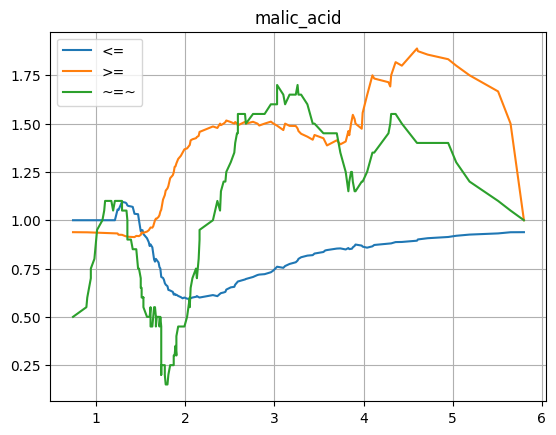

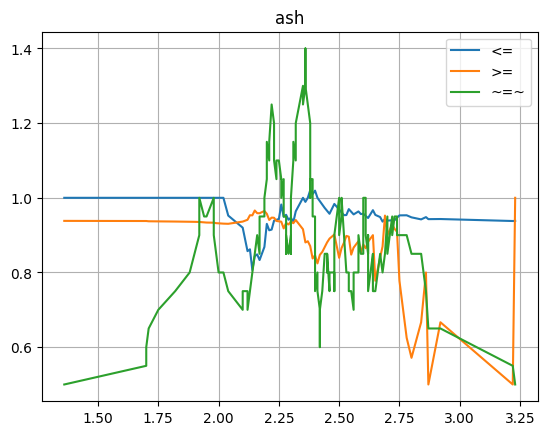

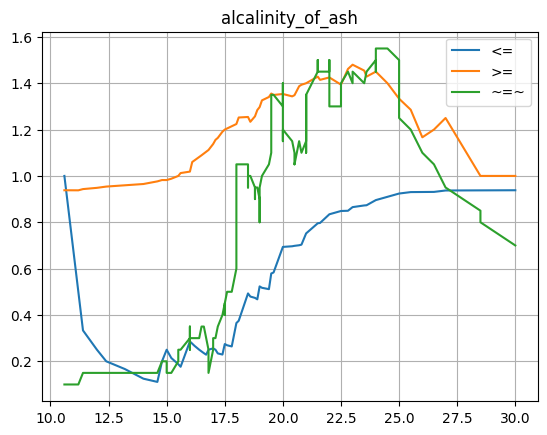

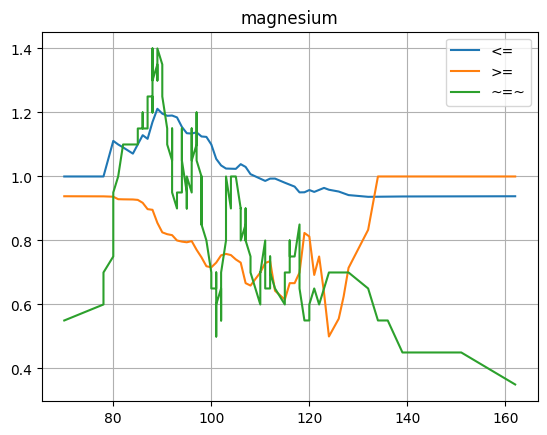

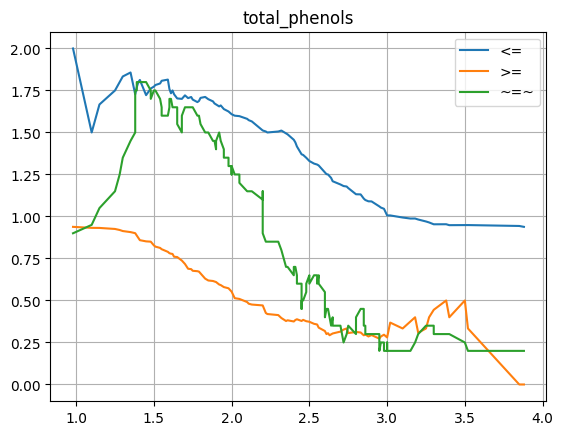

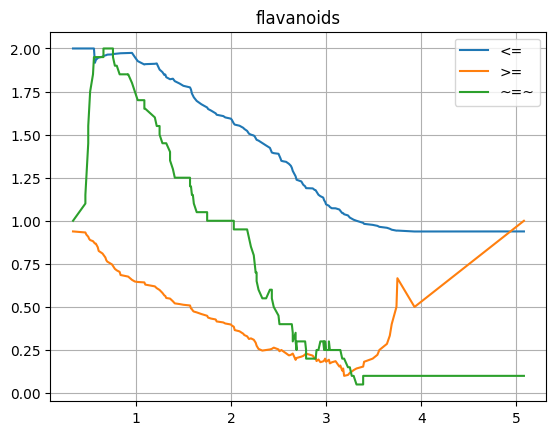

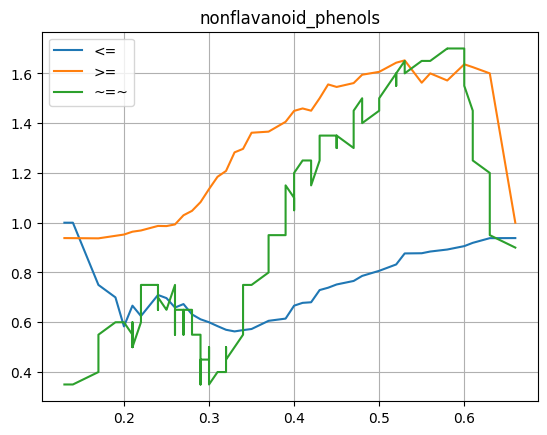

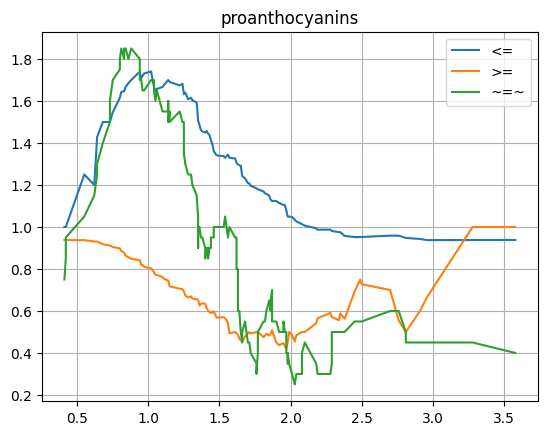

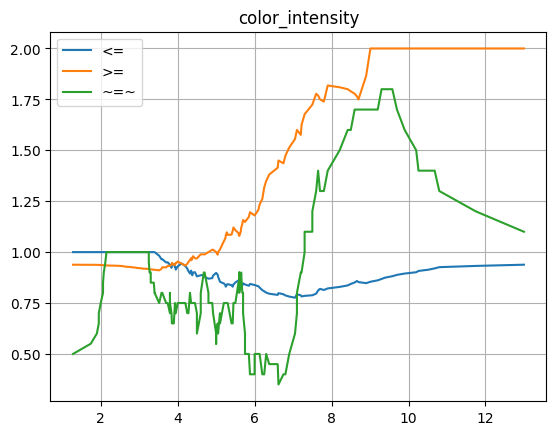

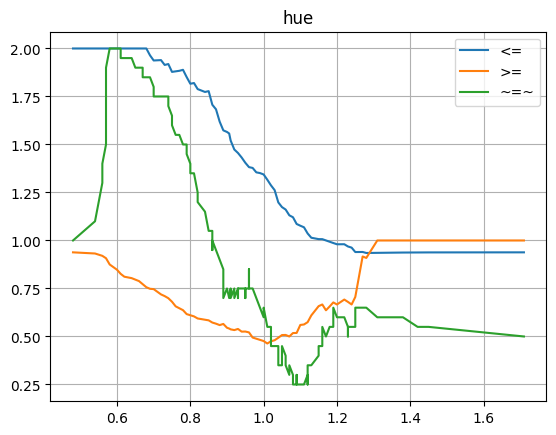

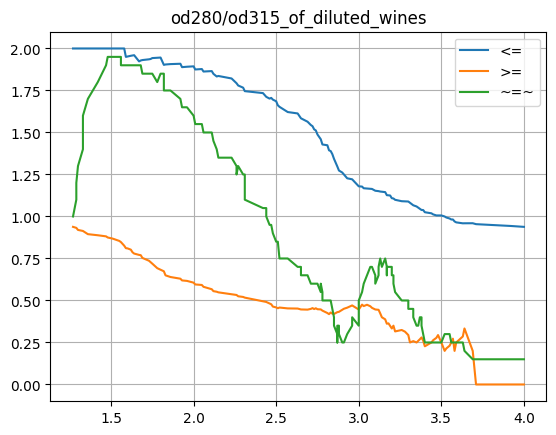

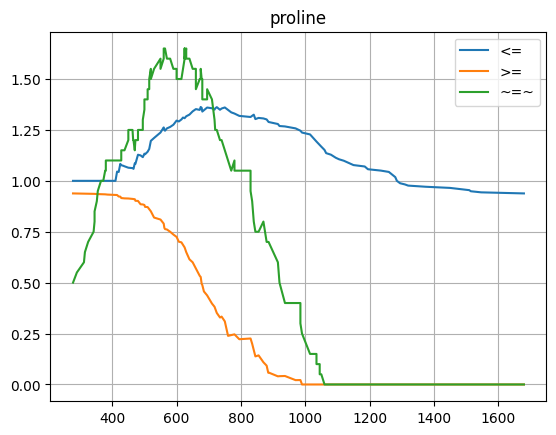

In [6]:
for col in df.columns.drop('target'):
    tmp = df.sort_values(col)
    plt.title(col)
    plt.plot(tmp[col], tmp[col].apply(lambda x: tmp[tmp[col] <= x].target.mean()), label="<=")
    plt.plot(tmp[col], tmp[col].apply(lambda x: tmp[tmp[col] >= x].target.mean()), label=">=")
    plt.plot(tmp[col], np.convolve(np.ones(20)/20, tmp.target, mode='same'), label= "~=~")
    plt.legend()
    plt.grid()
    plt.show()

Ok, let's just train a model. We are not interested in top performance right now so we will skip hyperparameter optimization. Also, we want to find the pattern in the data we have, so we don't split the data into validation and test set.

In [7]:
model = RandomForestRegressor()
x = df.drop('target', axis=1)
y = df.target
model.fit(x, y)

RandomForestRegressor()

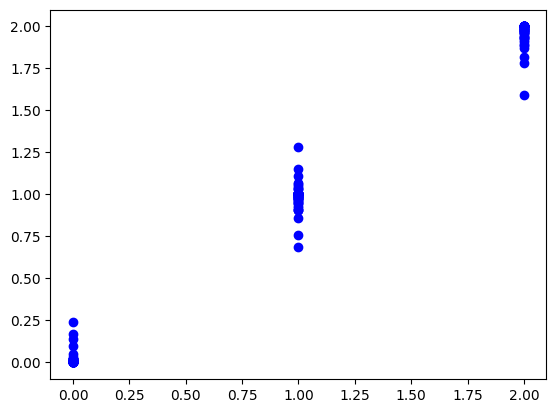

In [8]:
plt.plot(df.target, model.predict(x), 'bo')

Dalex is a python package for model explainability. We will use some of its functions to understand the data and the model better. First, we need to create an explainer model. Since we are not interested in checking the model performance but the relation between the data and the target we will use the whole dataset here. In the first case, we might want to use the testing set.

In [9]:
exp = dx.Explainer(model, x, y)

Preparation of a new explainer is initiated

  -> data              : 178 rows 13 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 178 values
  -> model_class       : sklearn.ensemble._forest.RandomForestRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x000001D2FFC936A0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.929, max = 2.0
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.28, mean = 0.00961, max = 0.41
  -> model_info        : package sklearn

A new explainer has been created!


In [10]:
fi = exp.model_parts()

exp.model_parts() computes the importance of each feature by measuring how much the model's performance degrades when each feature is shuffled (permuted). This is known as Permutation Feature Importance.

In [11]:
fi

The dropout_loss is a measure of how much the model's performance decreases when a particular feature is shuffled.

-Higher dropout_loss indicates that when a feature is shuffled, it has a significant negative impact on the model's performance, suggesting that the feature is highly important to the model's predictions. <br>
-Lower dropout_loss suggests that shuffling that feature does not significantly change the model's performance, indicating that the feature is not as crucial for the model.

The first step will be feature importance. It's a basic analysis where we calculate the global impact of a feature. The idea in dalex default approach is to measure **how much the model performance is worsening after removing this feature**. Of course, it would require retraining the model, the optimal set of hyperparameters might be different and it might affect the results. To avoid these problems **we do not retrain the model**. Instead, **we simulate its removal by assigning random values to it**. To make it more realistic **the values are not completely random, we just shuffle this column in a dataframe**, do the prediction, check performance and repeat these steps multiple times.

In [12]:
fi.plot()

Another useful tool is a partial dependency plot. For a given feature we observe what's the average output of our model for different values of this feature. For each considered value we set this value for each row in our dataframe and calculate an average prediction.

*A Partial Dependence Plot (PDP) shows how changing one feature affects the model's predictions, on average. It changes the feature's value across all data points and calculates the average prediction for each value.* <br>
*A straighter line in a Partial Dependence Plot (PDP) means that changes in that feature have little effect on the model’s predictions, indicating the feature has a smaller impact on the outcome.*

In [13]:
exp.model_profile().plot()

Calculating ceteris paribus: 100%|██████████| 13/13 [00:00<00:00, 38.22it/s]



We can also create similar plots for single rows. Here for each column, we present what would be the output from the model assuming we keep all remaining values and change the value of this one selected feature.

In [14]:
df.iloc[15]

alcohol                           13.63
malic_acid                         1.81
ash                                2.70
alcalinity_of_ash                 17.20
magnesium                        112.00
total_phenols                      2.85
flavanoids                         2.91
nonflavanoid_phenols               0.30
proanthocyanins                    1.46
color_intensity                    7.30
hue                                1.28
od280/od315_of_diluted_wines       2.88
proline                         1310.00
target                             0.00
Name: 15, dtype: float64

In [15]:
exp.predict_profile(x.iloc[[15,80]]).plot()

Calculating ceteris paribus:   0%|          | 0/13 [00:00<?, ?it/s]

Calculating ceteris paribus: 100%|██████████| 13/13 [00:00<00:00, 120.08it/s]


SHAP values are equivalents of Shapley values for the predictive models. It estimates the effect of a particular value of a particular feature for a prediction of a considered row. It's also done by replacing this value with proper sampling and replacing this value and measuring the effect on the prediction.

In [16]:
exp.predict_parts(x.iloc[15], type='shap').plot()

In [17]:
x.iloc[15]

alcohol                           13.63
malic_acid                         1.81
ash                                2.70
alcalinity_of_ash                 17.20
magnesium                        112.00
total_phenols                      2.85
flavanoids                         2.91
nonflavanoid_phenols               0.30
proanthocyanins                    1.46
color_intensity                    7.30
hue                                1.28
od280/od315_of_diluted_wines       2.88
proline                         1310.00
Name: 15, dtype: float64

In [18]:
exp.predict_parts(x.iloc[15], type='shap').plot()

In [19]:
exp.predict_parts(x.iloc[80], type='shap').plot()

The result is based on sampling so the result for the same row can vary

In [20]:
exp.predict_parts(x.iloc[88], type='shap').plot()

In [21]:
exp.predict_parts(x.iloc[88], type='shap').result

variable  contribution  \
0                  total_phenols = 1.95      0.000112   
1   od280/od315_of_diluted_wines = 2.75     -0.057022   
2                     malic_acid = 2.06      0.001517   
3                       alcohol = 11.64      0.106236   
4                            ash = 2.46      0.001067   
..                                  ...           ...   
8                     malic_acid = 2.06      0.003622   
9           nonflavanoid_phenols = 0.48     -0.001840   
10               proanthocyanins = 1.35     -0.001699   
11                           ash = 2.46      0.000121   
12                 total_phenols = 1.95     -0.000031   

                   variable_name  variable_value  sign                  label  \
0                  total_phenols            1.95   1.0  RandomForestRegressor   
1   od280/od315_of_diluted_wines            2.75  -1.0  RandomForestRegressor   
2                     malic_acid            2.06   1.0  RandomForestRegressor   
3                        alcohol           11.64   1.0  RandomForestRegressor   
4                            ash            2.46   1.0  RandomForestRegressor   
..                           ...             ...   ...                    ...   
8                     malic_acid            2.06   1.0  RandomForestRegressor   
9           nonflavanoid_phenols            0.48  -1.0  RandomForestRegressor   
10               proanthocyanins            1.35  -1.0  RandomForestRegressor   
11                           ash            2.46   1.0  RandomForestRegressor   
12                 total_phenols            1.95  -1.0  RandomForestRegressor   

    B  
0   1  
1   1  
2   1  
3   1  
4   1  
.. ..  
8   0  
9   0  
10  0  
11  0  
12  0  

[338 rows x 7 columns]

**Task** For each class find the most representative examples and plot breakdown for them.

Imagine we have a model classifying dogs and cats. Then a good example would be to show e.g. 3 breeds of dogs and the same with cats. Showing 5 golden retrievers although cute is not the best approach.

There isn't a single best way how to approach this task. There are many good solutions. Think about what you want to achieve and then how to do it

In [22]:
def find_representants(df, number_of_clusters):
    representative_samples = {}
    for wine_type in df['target'].unique():
        samples = df[df['target'] == wine_type].drop('target', axis = 1) #we leave only teh observations that are type that we want (0,1 or 2) 
        #and then drop the target column 
        kmedoids = KMedoids(n_clusters=number_of_clusters, random_state=106)
        kmedoids.fit(samples)
        medoid_id = kmedoids.medoid_indices_
        
        representative_samples[wine_type] = samples.index[medoid_id].tolist()
    return representative_samples
        


In [23]:
representative_samples = find_representants(df, number_of_clusters=3)
print(representative_samples)

{0: [48, 58, 25], 1: [109, 116, 125], 2: [142, 141, 148]}


In [24]:
representative_samples = find_representants(df, number_of_clusters=3)
#number_of_graphs = len(sample)
number_of_graphs = 3
for wine_type, sample_id in representative_samples.items():
    print(f"Representative sample for wine type {wine_type}: {sample_id}")
    for i in range(0, number_of_graphs):
        exp.predict_parts(x.iloc[sample_id[i]], type='shap').plot()
    #print("Data about the sample:")
    #print(df.iloc[sample])
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

Representative sample for wine type 0: [48, 58, 25]


----------------------------------------------------------------------------------------------------------------------------------------------
Representative sample for wine type 1: [109, 116, 125]


----------------------------------------------------------------------------------------------------------------------------------------------
Representative sample for wine type 2: [142, 141, 148]


----------------------------------------------------------------------------------------------------------------------------------------------


There are other approaches that can be used for model explainability.
 - LIME - approximating model locally by a linear model
 - Anchor - approximating model locally by a rule-based model
 - Prototype - justifying a new prediction by showing a similar example from the data (a prototype)
 - Counterfactual Explanation - showing a similar exmaple from the dataset with a different prediction to show what must be changed to change the prediction.

# Task

- take a dataset you want
- perform an exploratory data analysis (data visualization)
- create a sklearn pipeline for data preprocessing
- add new features (one hot encoding for example)
- add predictive model as the last step of the pipeline
- prepare a report with model explainability

Send it to gmiebs@cs.put.poznan.pl within 144 hours after the class is finished. Start the subject of the email with [IR]

Assume your report will be read by a domain expert from the area of the data, in our case a wine expert, without any computer science / data science skills. It means the person will not get much from raw plots and diagrams. Everything has to be explained to be understood.

---------------------------

In [116]:
# %pip install shap lime

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/275.7 kB ? eta -:--:--
     ----------------------- -------------- 174.1/275.7 kB 5.1 MB/s eta 0:00:01
     -------------------------------------- 275.7/275.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/456.1 kB ? eta -:--:--
   --------------------------------------- 456.1/456.1 kB 14.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   -- ------------------------------------- 0.9/12.8 MB 29.1 MB/s eta 0:00:01
   ------ --------------------------------- 2.2/12.8 MB 28.1 MB/s eta 0:00:01
   ---------- ----------------------------- 3.5/12.8 MB 27.6 MB/s eta 0:00:01
   --------------- ------------------------ 4.9/12.8 MB 28.3 MB/s eta 0:00:01
   ------------------- -------------------- 6.3/12.8 M

DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [191]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import shap
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

<h3>Understanding Dataset

In [192]:
student_data = pd.read_csv("student_data.csv")
#
# SUMMARY STATISTICS
#
print("\nSumary statistics for categorical data:\n",student_data.describe(include='object'))
print("\nSumary statistics for continous data:\n",student_data.describe().round(1))
student_data.head()
student_data.info()
print("Missing values:\n", student_data.isnull().sum())
#NO MISSING VALUES


Sumary statistics for categorical data:
        school  sex address famsize Pstatus   Mjob   Fjob  reason guardian  \
count     395  395     395     395     395    395    395     395      395   
unique      2    2       2       2       2      5      5       4        3   
top        GP    F       U     GT3       T  other  other  course   mother   
freq      349  208     307     281     354    141    217     145      273   

       schoolsup famsup paid activities nursery higher internet romantic  
count        395    395  395        395     395    395      395      395  
unique         2      2    2          2       2      2        2        2  
top           no    yes   no        yes     yes    yes      yes       no  
freq         344    242  214        201     314    375      329      263  

Sumary statistics for continous data:
          age   Medu   Fedu  traveltime  studytime  failures  famrel  freetime  \
count  395.0  395.0  395.0       395.0      395.0     395.0   395.0     395.

No missing values. 


<h3>Target Variable analysis

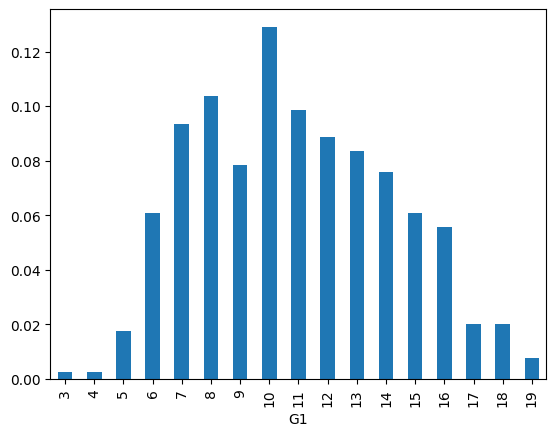

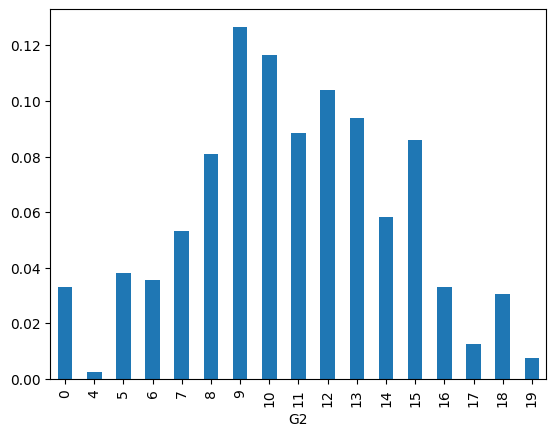

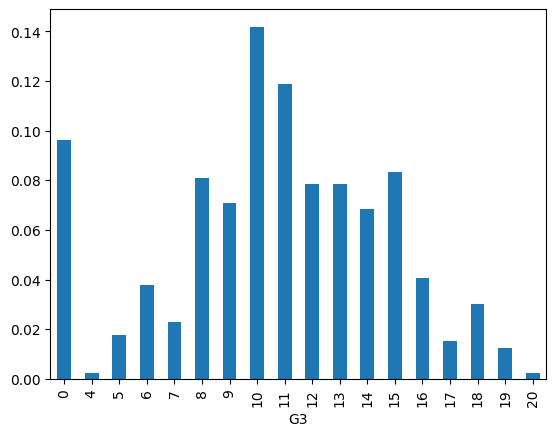

In [193]:
student_data['G1'].value_counts(normalize=True).sort_index().plot(kind='bar')
plt.show()
student_data['G2'].value_counts(normalize=True).sort_index().plot(kind='bar')
plt.show()
student_data['G3'].value_counts(normalize=True).sort_index().plot(kind='bar')
plt.show()

We can see that there is a majority of 10. This is due to 10 being the treshold for passing. Teachers are improving grades for students to pass.
Overall distribution is looking normal(Gaussian)
Because they look simillar, we will use median of grades for each student to classify, and we will convert 0-20 system to F-A grading.
We see the 0's in 2nd and 3rd grade, but decided to predict overall score in school for a student.

<h3>Univariate analysis


Histogram of all features:



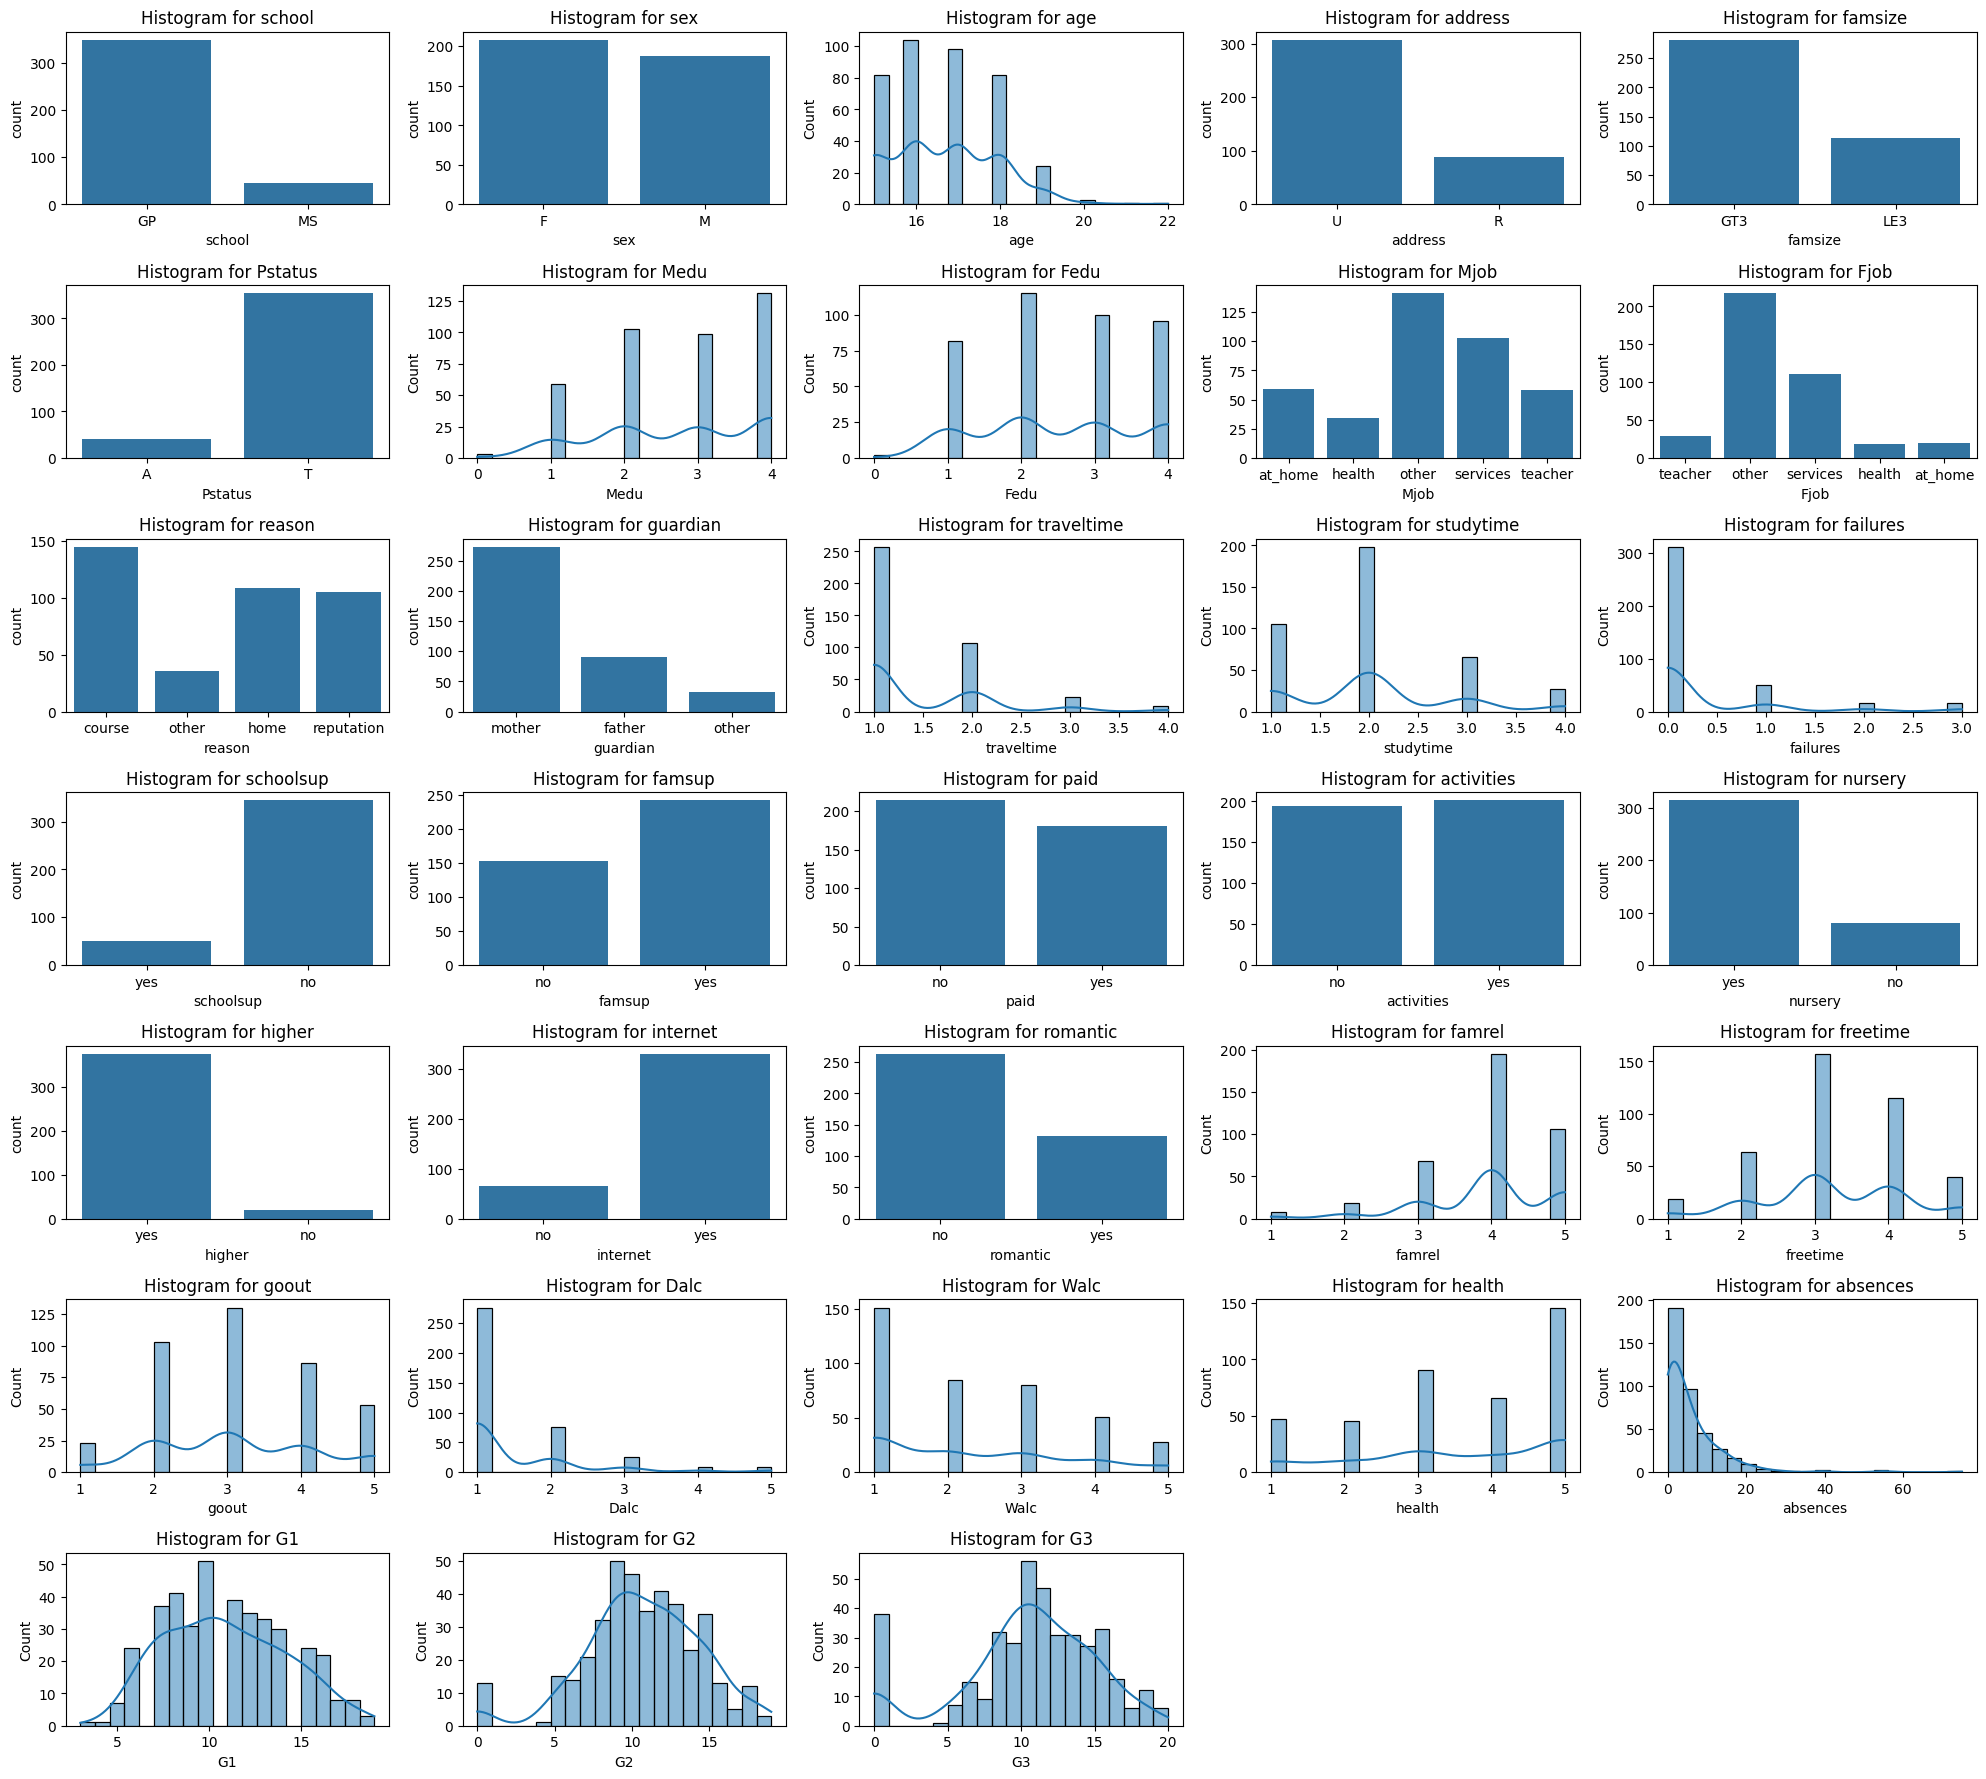

In [194]:
print("\nHistogram of all features:\n")
student_data.columns
plt.figure(figsize = (20,20))
for i, column in enumerate(student_data.columns, 1):
    plt.subplot(8,5,i)
    if student_data[column].dtype == 'object':
        sns.countplot(x=column, data=student_data)
    else:
        sns.histplot(data=student_data[column], bins=20, kde=True) #stat='percent', bins=20
    plt.title(f'Histogram for {column}')
plt.tight_layout()
plt.show()

<h3>Bivariate Analysis (Two variables-feature vs target)


Histogram of categorical features against grades:



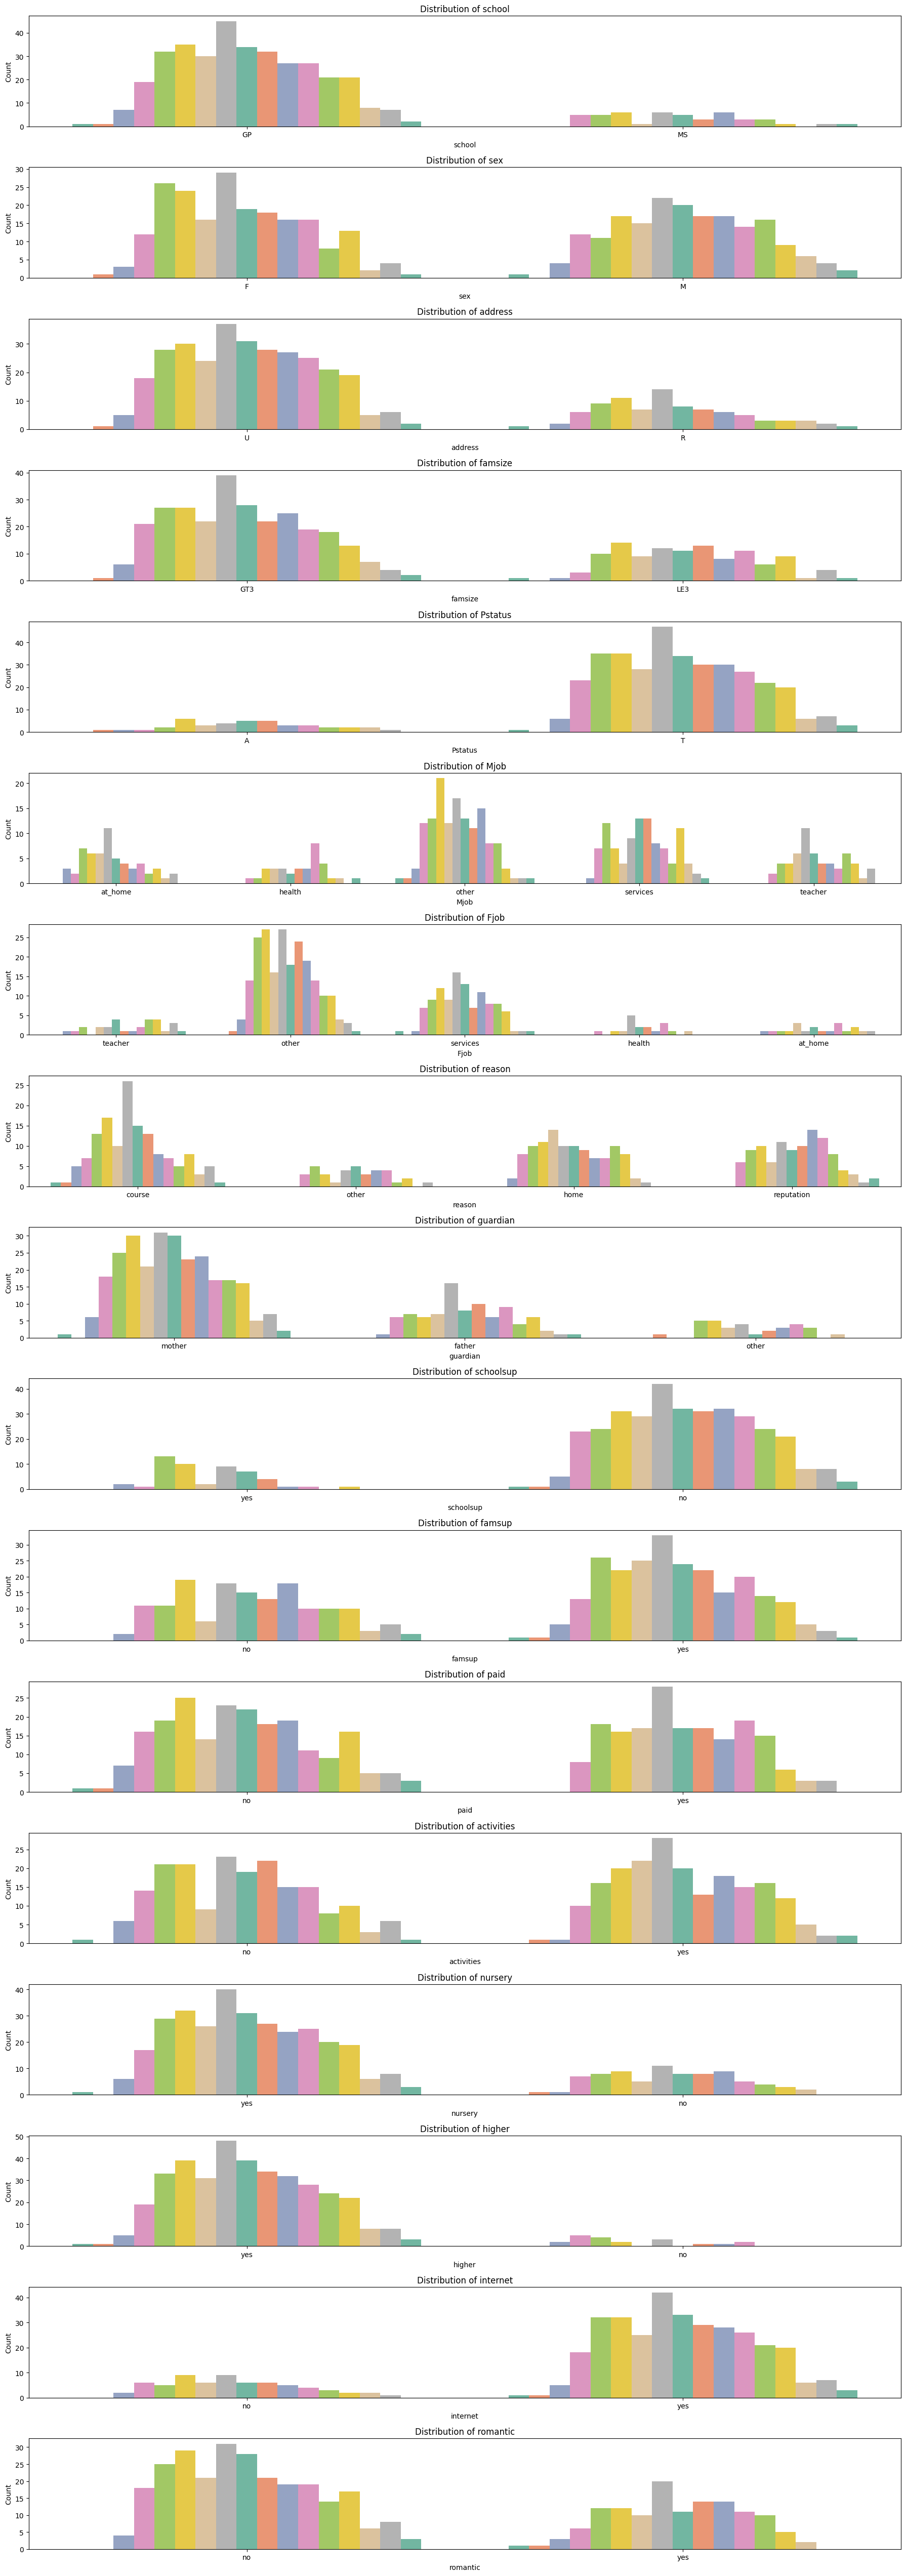


Boxplot of numerical features against grades:



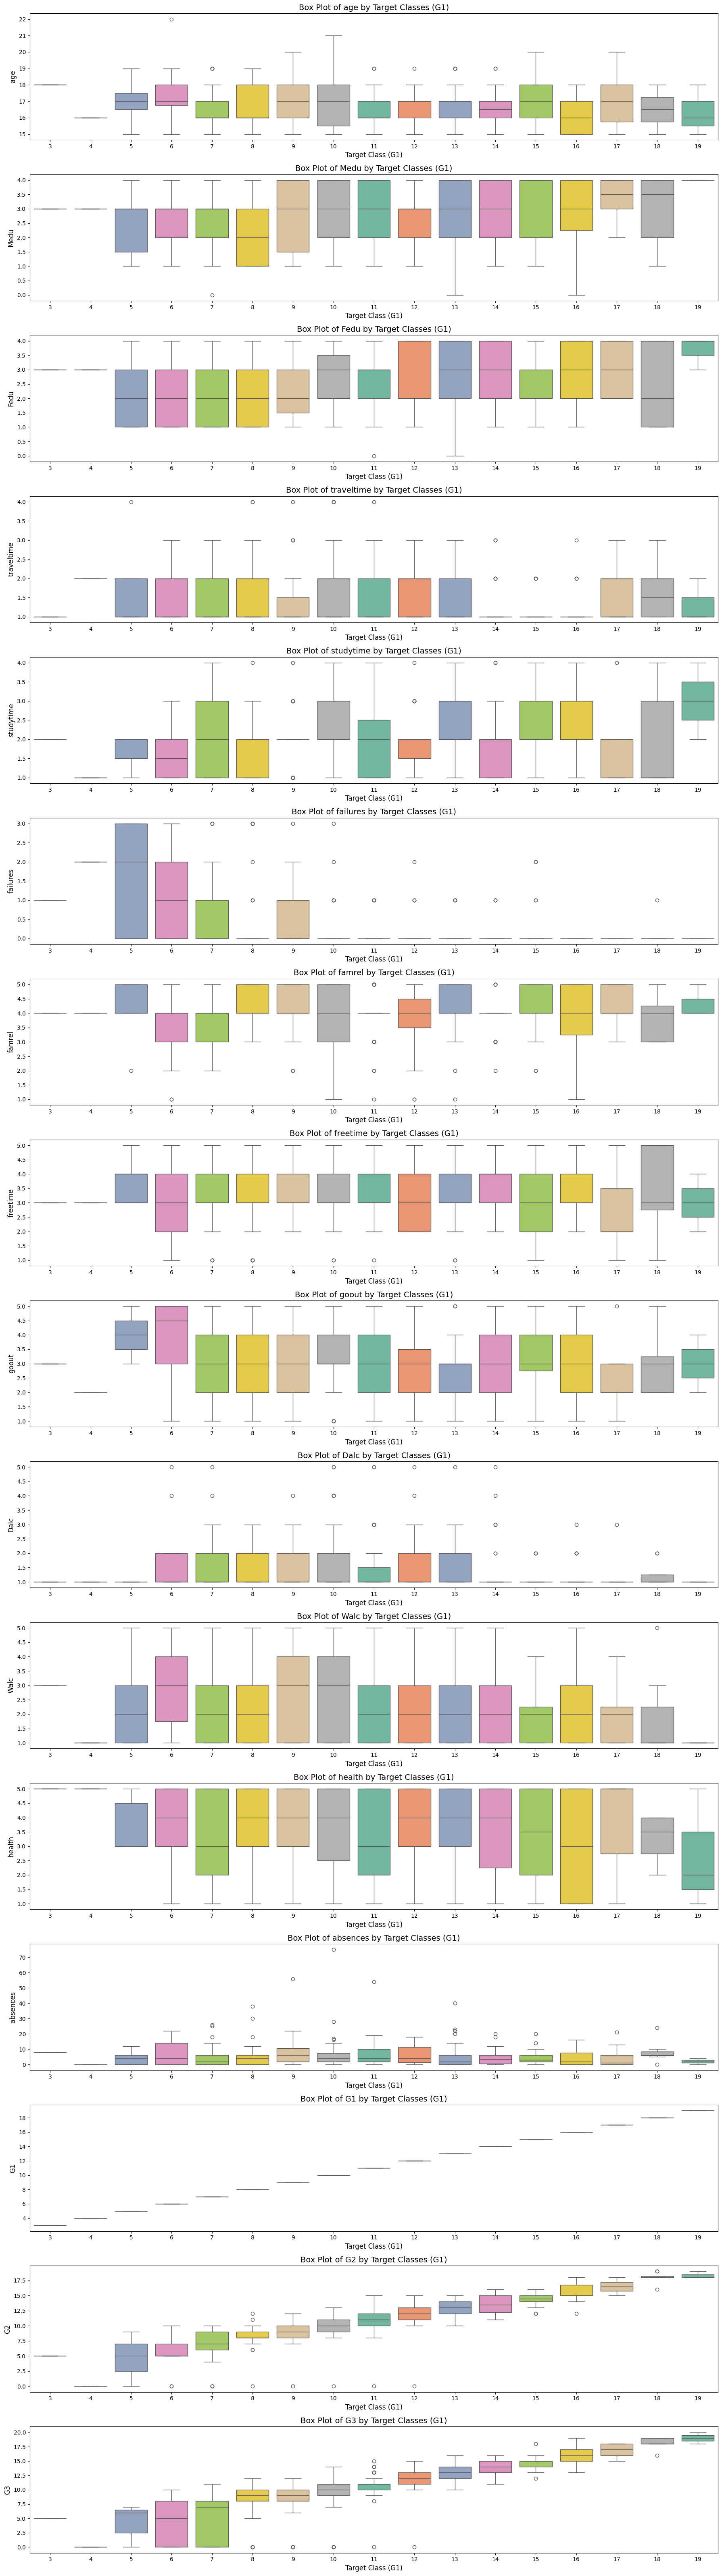

In [195]:
categorical = [column for column in student_data.columns if student_data[column].dtype == 'object']
numerical = [column for column in student_data.columns if student_data[column].dtype in ['int64', 'float64']]
print("\nHistogram of categorical features against grades:\n")

# Categorical features plot
plt.figure(figsize=(18, len(categorical) * 3)) 
for i, column in enumerate(categorical, 1):
    plt.subplot(len(categorical), 1, i)  
    sns.countplot(x=column, data=student_data, hue='G1', palette='Set2')
    plt.title(f'Distribution of {column}', fontsize=12)
    plt.xlabel(column, fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.legend([],[], frameon=False) 

plt.tight_layout()
plt.show()

print("\nBoxplot of numerical features against grades:\n")

plt.figure(figsize=(18, len(numerical) * 4)) 
for i, column in enumerate(numerical, 1):
    plt.subplot(len(numerical), 1, i)
    sns.boxplot(x='G1', y=column, data=student_data, palette='Set2', hue='G1') 
    plt.title(f'Box Plot of {column} by Target Classes (G1)', fontsize=14)
    plt.xlabel('Target Class (G1)', fontsize=12)
    plt.ylabel(column, fontsize=12)    
    plt.legend([],[], frameon=False) 


plt.tight_layout()
plt.show()

<h3>Multivaraite analysis


Correlation heatmap:



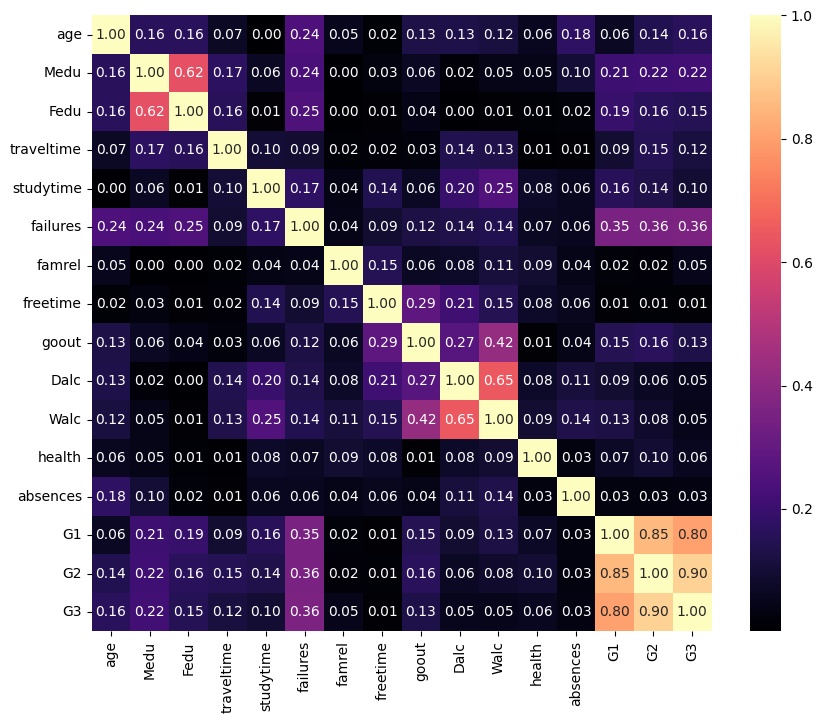

In [196]:
print("\nCorrelation heatmap:\n")
plt.figure(figsize=(10,8))
sns.heatmap(abs(student_data[student_data.columns[student_data.dtypes == np.int64]].corr()), cmap='magma',annot=True, fmt=".2f")
plt.show()

# sns.pairplot(student_data, hue='G1')

<h3>Feature Engeineering

In [197]:
student_data = pd.read_csv("student_data.csv")
print(student_data.columns)
print(student_data.shape)

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')
(395, 33)


Manually deleting some features, binning target value

In [198]:
# CREATING THE TARGET-GRADES AS MEAN FROM 3 YEARS
student_data['Grades'] = student_data[['G1', 'G2', 'G3']].mean(axis=1)
# Binarize the grades into 5 bins
bins = [0, 9, 13, 15, 17, 20]
labels = ['F', 'D', 'C', 'B', 'A']
student_data['Grade'] = pd.cut(student_data['Grades'], bins=bins, labels=labels, right=True)
student_data.drop(columns=['G1', 'G2', 'G3', 'Grades'], inplace=True)
student_data.drop(columns=['age', 'traveltime', 'freetime'], inplace=True)

Splitting dataset

In [210]:
# Split the data
X = student_data.drop(columns=['Grade'])
y = student_data['Grade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [200]:
###Too complicated to mix with pipeline. 
# # Perform ANOVA
# X = student_data.drop(columns=['Grade'])
# y = student_data['Grade']
# anova_results = f_classif(X.select_dtypes(include=['object']), y)
# p_values = anova_results[1]
# selected_features = X.columns[p_values < 0.05]
# print(selected_features)

<h3>Sklearn pipeline preprocessing

In [211]:
#pipeline doesnt have threshold encoding by default, so im making my own transformer
def binarize_absences(X):
    threshold = 12  # Define your threshold
    return (X > threshold).astype(int)


ordinal_features = ['Medu', 'Fedu', 'studytime', 'failures', 'goout', 'Dalc', 'Walc', 'health', 'famrel']  # Numeric ordinal features
categorical_features = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'reason', 'guardian', 
                        'Mjob', 'Fjob']  # Include other categorical features as needed
binary_features = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'romantic', 'internet']  # Binary features
binary_threshold_feature = ['absences']


preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(), ordinal_features),
        ('categorical', OneHotEncoder(), categorical_features),
        ('binary', OneHotEncoder(), binary_features),
        ('binarize', FunctionTransformer(binarize_absences, validate=False), binary_threshold_feature)
    ],
    remainder='passthrough'  # Leave other features untouched
)

# Create the pipeline, add predictive model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))  # set 42 for reproducibility
])

# Fit the pipeline on the data (X, y)
pipeline.fit(X, y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal', OrdinalEncoder(),
                                                  ['Medu', 'Fedu', 'studytime',
                                                   'failures', 'goout', 'Dalc',
                                                   'Walc', 'health',
                                                   'famrel']),
                                                 ('categorical',
                                                  OneHotEncoder(),
                                                  ['school', 'sex', 'address',
                                                   'famsize', 'Pstatus',
                                                   'reason', 'guardian', 'Mjob',
                                                   'Fjob']),
                                                 ('binary', OneHotEncoder(),
                                                  ['schoolsup', 'famsup',
                                                   'paid', 'activities',
                                                   'nursery', 'higher',
                                                   'romantic', 'internet']),
                                                 ('binarize',
                                                  FunctionTransformer(func=<function binarize_absences at 0x000001D2B6780D60>),
                                                  ['absences'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

<h5>Checking model performance

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         3
           B       1.00      1.00      1.00         8
           C       1.00      1.00      1.00        14
           D       1.00      1.00      1.00        22
           F       1.00      1.00      1.00        32

    accuracy                           1.00        79
   macro avg       1.00      1.00      1.00        79
weighted avg       1.00      1.00      1.00        79



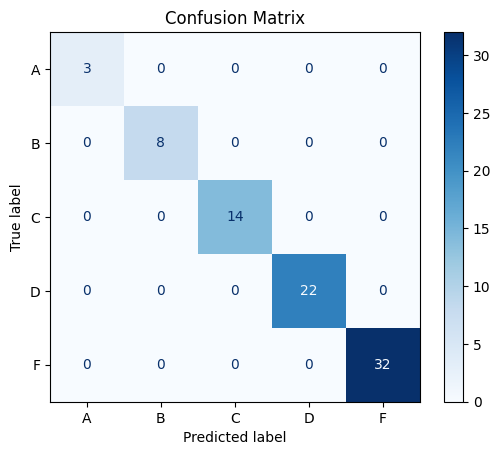

In [212]:
y_pred  = pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

report = classification_report(y_test, y_pred)
print(report)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()



<h3>SHAP explainability - this doesnt yet works. Whats left is this and report.

In [213]:
# Use SHAP to explain the model
explainer = shap.Explainer(pipeline.named_steps['classifier'], pipeline.named_steps['preprocessor'].transform(X))
shap_values = explainer.shap_values(pipeline.named_steps['preprocessor'].transform(X))

# Plot SHAP values
shap.summary_plot(shap_values, X)

 99%|===================| 1949/1975 [00:24<00:00]        

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.